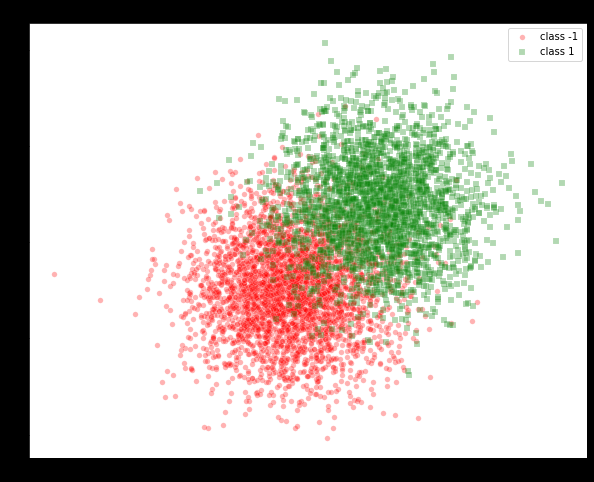

In [43]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
# тестовая модель, создаем синтетические данные data0
def data0(rg=13, n=6000, m=2500):
    np.random.seed(rg)
    x0 = np.random.normal(loc=0, scale=1, size=(n, 2))
    x0[:m, :] += 0.75
    x0[m:, :] -= 1
    x = np.zeros((n, 3))
    x[:, 0] = 1
    x[:, 1] = x0[:, 0]
    x[:, 2] = x0[:, 1]
    y = np.array([1] * m + [-1] * (n - m))  # целевой вектор классов {-1; 1}
    return x0, x, y

data = data0()
def settings_graph():
    f, axel = plt.subplots(1, 1)
    f.set(facecolor="0", figwidth=10, figheight=8)
    axel.set(facecolor="white")
    axel.set(facecolor="white")
    return f, axel
def show_data():
    f, axel = settings_graph()
    axel.scatter(
        data[0][data[2] == -1, 0],
        data[0][data[2] == -1, 1],
        color="red",
        s=30,
        linewidths=0.4,
        edgecolors="white",
        label="class -1",
        alpha=0.3,
    )
    axel.scatter(
        data[0][data[2] == 1, 0],
        data[0][data[2] == 1, 1],
        color="green",
        s=30,
        linewidths=0.4,
        edgecolors="white",
        marker="s",
        label="class 1",
        alpha=0.3
    )
    axel.set_title("График сгенерированных (т.е синтентических) данных")
    axel.legend()

show_data()

#### видим что данные хоть и немного смешиваются на границе, но все же линейно разделимы достаточно хорошо, поэтому выбираем логистическую регрессию как модель для бинарной классификации

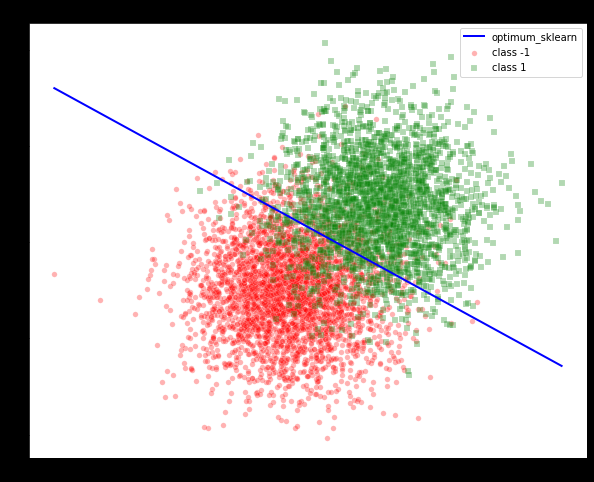

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    data0()[0], data0()[2], test_size=0.2, random_state=42, stratify=data0()[2]
)

def baseline_train(): # в качестве основного прогноза строим модель без регуляриции и без подбора гиперпараметров
    clf = SGDClassifier(max_iter=1000, learning_rate="constant", eta0=0.1, random_state=13)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X=X_test)  # предсказание классов, которое делает классификатор из sklearn
    w0, w1, w2 = [clf.intercept_[0], clf.coef_[0][0], clf.coef_[0][1]]  # оптимальный вектор весов
    return [w0, w1, w2, y_pred]

def show_optimum_vector(data): # визуализируем построенную оптимальную прямую,
    # разделяющую два класса {-1; 1}
    f, axel = settings_graph()
    axel.scatter(
        data[0][data[2] == -1, 0],
        data[0][data[2] == -1, 1],
        color="red",
        s=30,
        linewidths=0.4,
        edgecolors="white",
        label="class -1",
        alpha=0.3,
    )
    axel.scatter(
        data[0][data[2] == 1, 0],
        data[0][data[2] == 1, 1],
        color="green",
        s=30,
        linewidths=0.4,
        edgecolors="white",
        marker="s",
        label="class 1",
        alpha=0.3
    )

    x1 = np.linspace(data[0][:, 0].min(), data[0][:, 0].max(), 1000)
    x2 = (-baseline_train()[0] - baseline_train()[1] * x1) / baseline_train()[2]
    axel.plot(x1, x2, color="b", label="optimum_sklearn", linewidth=2)  # строим разделяющюю прямую лог.регрессии
    axel.set_title("График сгенерированных (т.е синтентических) данных")
    axel.legend()

show_optimum_vector(data)

In [40]:
# вычисляем метрики качества лог.регр.
def data_metrics(ytest, ypred_class, ypred_proba):
    metrics = pd.DataFrame(
        {
            "метрика": [
                roc_auc_score(ytest, ypred_proba),
                precision_score(ytest, ypred_class),
                recall_score(ytest, ypred_class),
                accuracy_score(ytest, ypred_class),
                log_loss(ytest, ypred_class),
            ],
            "комментарий": [*["чем больше тем лучше" for i in range(4)], "чем меньше тем лучше"],
        },
        index=["roc_auc_score", "precision_score", "recall_score", "accuracy_score", "log_loss"],
    )
    return metrics

def y_pred_baseline_probabality():  # массив предсказанных верояттностей классификатора SGDClassifier
    # без кроссвалидации - Baseline прогноз
    W = np.array(baseline_train()[:3])
    X_ = np.zeros((X_test.shape[0], 3))
    X_[:, 0] = 1
    X_[:, 1] = X_test[:, 0]
    X_[:, 2] = X_test[:, 1]
    a = X_.dot(W)
    return 1 / (1 + np.exp(-a))

baseline = data_metrics(y_test, baseline_train()[3], y_pred_baseline_probabality())
baseline # выводим на экран метрики базовой модели

,метрика,комментарий
roc_auc_score,0.955149,чем больше тем лучше
precision_score,0.868526,чем больше тем лучше
recall_score,0.872000,чем больше тем лучше
accuracy_score,0.891667,чем больше тем лучше
log_loss,3.741745,чем меньше тем лучше


теперь попробуем улучшить модель классификации
с помощью подбора гипперпараметров на кросс-валидации

In [42]:
def cross_val_train():
    log_reg = LogisticRegression(class_weight="balanced")
    param_grid = {
        "penalty": ["l1", "l2", "elasticnet"],
        "C": np.linspace(1, 1000, num=10),
        "solver": ["lbfgs", "saga", "lbfgs"],
    }
    cv = StratifiedKFold(n_splits=5,shuffle=True)
    grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring="roc_auc")  # ,verbose=2)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    log_reg_best = LogisticRegression(**best_params, class_weight="balanced")
    log_reg_best.fit(X_train, y_train)
    y_best_prediction = log_reg_best.predict(X_test)
    y_proba_best = log_reg_best.predict_proba(X_test)[:, 1]
    return [y_best_prediction, y_proba_best]


best_model = data_metrics(y_test, cross_val_train()[0], cross_val_train()[1])
best_model # выводим на экран метрики лучшей модели

,метрика,комментарий
roc_auc_score,0.960214,чем больше тем лучше
precision_score,0.865643,чем больше тем лучше
recall_score,0.902000,чем больше тем лучше
accuracy_score,0.900833,чем больше тем лучше
log_loss,3.425142,чем меньше тем лучше


In [52]:
# посмотрим как изменились метрики оптимальной (лучшей) модели по сравнению с базовой
improvement = baseline.copy()
improvement['метрика'] = 100 * (best_model['метрика'] - baseline['метрика']) / baseline['метрика']
improvement.columns = ['изменение_метрики_в_%','комментарий']
improvement['комментарий'] = [*['% процент изменения должен быть положительный' for i in range(4)], '% процент изменения должен быть отрицательным']
improvement

,изменение_метрики_в_%,комментарий
roc_auc_score,0.530359,% процент изменения должен быть положительный
precision_score,-0.331930,% процент изменения должен быть положительный
recall_score,3.440367,% процент изменения должен быть положительный
accuracy_score,1.028037,% процент изменения должен быть положительный
log_loss,-8.461368,% процент изменения должен быть отрицательным


Как видим, кроссвалидация дала очень хороший результат.
Теперь решим задачу на совмещение точности и полноты:
при точности precision_score > = 0.95% максимизируем полноту recall_score 

In [59]:
def y_pred_t(ypred, threshold):  # предсказание вероятностей клсаа 1 на основе порога threshold
    y_pred_threshold = np.zeros_like(y_test)
    y_pred_threshold[ypred > threshold] = 1
    y_pred_threshold[ypred <= threshold] = -1
    return y_pred_threshold

precision_array, recall_array, thresholds = precision_recall_curve(y_test, cross_val_train()[1])
ind = np.where(precision_array >= 0.95)
indt = np.min(ind)
t0 = thresholds[indt]
y_pred_t0 = y_pred_t(cross_val_train()[1], t0)

best_model_th = data_metrics(y_test, y_pred_t0, cross_val_train()[1])

# строим PR_curve ROC-curve оптимальной модели через sklearn
def show_metric_curve():
    f2, axel2 = plt.subplots(1, 2)
    f2.set(facecolor="0")
    axel2[0].set(facecolor="white")
    axel2[1].set(facecolor="white")
    axel2[0].plot(precision_array, recall_array, color="b", label="PR_curve")
    axel2[0].legend()
    FPR, R, thresholds = roc_curve(y_test, cross_val_train()[1])
    axel2[1].plot(FPR, R, color="r", label="ROC_curve")
    axel2[1].legend()
    plt.show()


best_model_th # при заданной точности P>=95% максимизировать полноту R

,метрика,комментарий
roc_auc_score,0.960217,чем больше тем лучше
precision_score,0.950131,чем больше тем лучше
recall_score,0.724000,чем больше тем лучше
accuracy_score,0.869167,чем больше тем лучше
log_loss,4.518836,чем меньше тем лучше


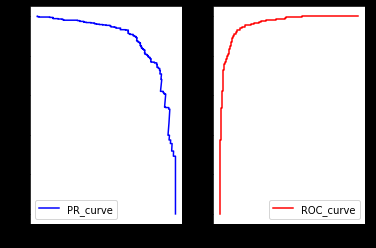

In [60]:
show_metric_curve()

### *После настройки гипперпараметров, получили очень хорошие метрики прогноза*